<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/JobShop_CP_ORTools_Idle_time.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Developed by Alireza Soroudi
alireza.soroudi@gmail.com

Linkedin News letter : https://www.linkedin.com/newsletters/optimization-in-open-source-6874020019009859585/

Git hub: https://github.com/OptimizationExpert/Pyomo



In [150]:
!pip install ortools
from ortools.sat.python import cp_model # CP-SAT solver
import numpy as np
from random import randint
import random
from math import ceil
import pandas as pd
import matplotlib.pyplot as plt # Data visualization
from matplotlib.patches import Rectangle

In [151]:
data = [
    [1, 3, 6, 7, 3, 6],
    [8, 5, 10, 10, 10, 4],
    [5, 4, 8, 9, 1, 7],
    [5, 5, 5, 3, 8, 9],
    [9, 3, 5, 4, 3, 1],
    [3, 3, 9, 10, 4, 1]
]

# Define the row and column labels
rows = [f'R{i+1}' for i in range(len(data))]
columns = [f'J{j+1}' for j in range(len(data[0]))]

# Create the DataFrame
dfpr = pd.DataFrame(data, index=rows, columns=columns)
dfpr

data = [
    [3, 1, 2, 4, 6, 5],
    [2, 3, 5, 6, 1, 4],
    [3, 4, 6, 1, 2, 5],
    [2, 1, 3, 4, 5, 6],
    [3, 2, 5, 6, 1, 4],
    [2, 4, 6, 1, 5, 3]
]
order = {f"R{r}":[f'J{j}' for j in data[r-1]] for r in range(1,7)}
order

{'R1': ['J3', 'J1', 'J2', 'J4', 'J6', 'J5'],
 'R2': ['J2', 'J3', 'J5', 'J6', 'J1', 'J4'],
 'R3': ['J3', 'J4', 'J6', 'J1', 'J2', 'J5'],
 'R4': ['J2', 'J1', 'J3', 'J4', 'J5', 'J6'],
 'R5': ['J3', 'J2', 'J5', 'J6', 'J1', 'J4'],
 'R6': ['J2', 'J4', 'J6', 'J1', 'J5', 'J3']}

In [152]:
jobs = [j for j in dfpr.columns]
machines = [r for r in dfpr.index]
jobs, machines

(['J1', 'J2', 'J3', 'J4', 'J5', 'J6'], ['R1', 'R2', 'R3', 'R4', 'R5', 'R6'])

In [153]:
KOLORS = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
            "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
            "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
            "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
            "#8c6d31", "#9c9ede", "#637939", "#e7cb94", "#b5cf6b",
            "#cedb9c", "#c7c7c7", "#bd9e39", "#e7969c", "#7b4173"]

In [154]:
def plot_results():
  m = (1+np.sqrt(5))*0.5
  plt.figure(figsize=(4*m,4))
  results_day = {}
  all = []
  allocated =[]
  for m in machines:
    y = machines.index(m) +1
    #
    for j in jobs:
      x1,x2 = solver.Value(st[j,m]),solver.Value(st[j,m]) +  int(dfpr.loc[m,j])
      jn= jobs.index(j)
      plt.gca().add_patch(Rectangle((x1,y),  int(dfpr.loc[m,j]),0.4,linewidth=1,edgecolor='k',facecolor=KOLORS[jn], alpha =0.6))

  #plt.yticks(range(len(actors)), actors, fontweight='bold')
  #plt.xticks(all,allocated)
  plt.xlim(0,0*solver.value(span)+110)
  plt.ylim(0.2,7)
  plt.yticks(range(1,1+len(machines)), machines)
  plt.grid()
  plt.tight_layout()
  plt.xlabel("Time")
  plt.ylabel("Machine")
  plt.show()


In [155]:
def opt_schd(w1,w2):

  model = cp_model.CpModel()
  solver = cp_model.CpSolver()

  st = {(j,m):model.NewIntVar(0,100, f"scen_day_{j}_{m}")  for j in jobs for m in machines}
  uinterval = {(j,m):model.NewFixedSizeIntervalVar(v_st,int(dfpr.loc[m,j]), f"interval_{j}_{m}") for (j,m),v_st in st.items()}
  span = model.NewIntVar(0,100, 'span')
  min_m = {m:model.NewIntVar(0,100, f"minstart_{m}") for m in machines}
  max_m = {m:model.NewIntVar(0,100, f"maxend_{m}") for m in machines}
  job_order = {(j1,j2):model.NewBoolVar(f"scen_day_{j1}_{j2}")  for j1 in jobs for j2 in jobs if j1!=j2}

  for (j1,j2),v in job_order.items():
    if j1>j2:
      model.AddExactlyOne([v,job_order[j2,j1]])
  for m in machines:
    expressions_st = [st[j,m] for j in jobs]
    expressions_fn = [st[j,m]+int(dfpr.loc[m,j]) for j in jobs]
    model.AddMinEquality(min_m[m],expressions_st)
    model.AddMaxEquality(max_m[m],expressions_fn)
    expressions = [uinterval[j,m] for j in jobs ]
    model.AddNoOverlap(expressions)
    for (j1,j2),v in job_order.items():
      model.Add(st[j1,m] + dfpr.loc[m,j1]<= st[j2,m]).OnlyEnforceIf(job_order[j1,j2])

  for m_index in range(1,len(machines)):
    m1 = machines[m_index-1]
    m2 = machines[m_index]
    for j in jobs:
      model.Add(st[j,m1] + dfpr.loc[m1,j] <= st[j,m2])

  for m in machines:
    expressions = [uinterval[j,m] for j in jobs ]
    model.AddNoOverlap(expressions)
    for (j1,j2),v in job_order.items():
      model.Add(st[j1,m] + dfpr.loc[m,j1]<= st[j2,m]).OnlyEnforceIf(job_order[j1,j2])

  for (j,m),v in st.items():
    model.Add(v+dfpr.loc[m,j] <=span)


  #model.Minimize(span)

  expr_obj = [max_m[m]-min_m[m] for m in machines]
  model.Minimize(w1*span + w2*sum(expr_obj))


  solver.parameters.max_time_in_seconds = 60
  status = solver.Solve(model)

  if status == cp_model.OPTIMAL:
    print("OPTIMAL")
  elif status == cp_model.FEASIBLE:
    print("FEASIBLE")
  elif status == cp_model.INFEASIBLE:
    print("INFEASIBLE")
    print("FEASIBLE")
  elif status == cp_model.UNKNOWN:
    print("UNKNOWN")
  print(solver.ObjectiveValue())
  print(solver.value(span), solver.value(sum(expr_obj)) )
  return solver, st


In [156]:
machines[:-1]

['R1', 'R2', 'R3', 'R4', 'R5']

OPTIMAL
66.0
66 253


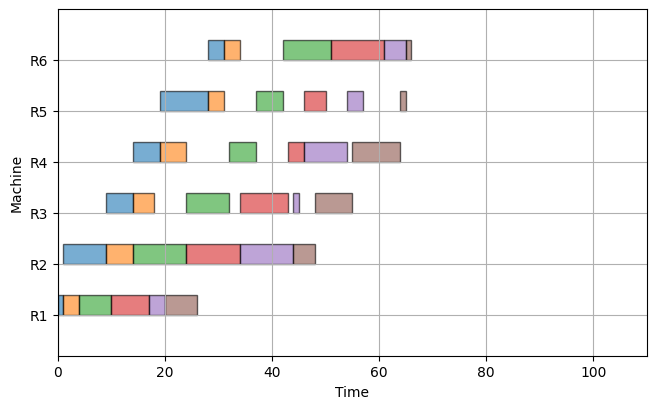

In [157]:
solver, st = opt_schd(1,0)
plot_results()
#for m in machines:
#  assigned = [dfpr.loc[m,j] for j in jobs]
#  print(m,sum(assigned) , solver.Value(max_m[m]), solver.Value(min_m[m]))

FEASIBLE
19775.0
75 197


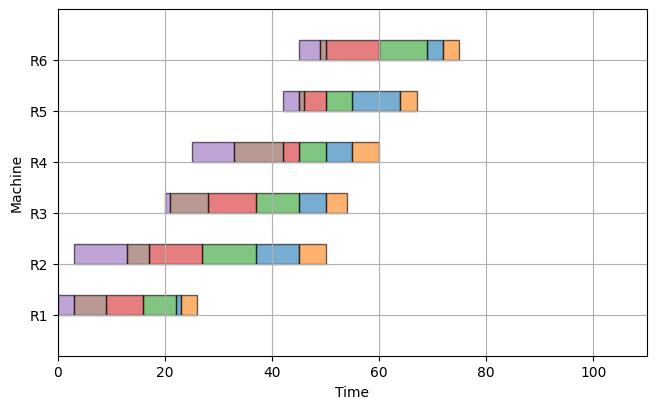

In [158]:
solver, st = opt_schd(1,100)
plot_results()

## Plot function